In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime

In [2]:
train_abbr=pd.read_excel("train_data.xlsx",encoding='ISO-8859-1')
train=pd.read_excel("train_data.xlsx",encoding='ISO-8859-1')
test_abbr=pd.read_excel("test_data.xlsx",encoding='ISO-8859-1')
test=pd.read_excel("test_data.xlsx",encoding='ISO-8859-1')
test_sub=pd.read_excel("result.xlsx",encoding='ISO-8859-1')

In [3]:
test.shape

(96, 12)

In [4]:
test_sub.shape

(0, 0)

In [5]:
train.shape

(5664, 12)

In [6]:
train.head()

,date,time,price1,MW1,MW2,MW3,MW4,MW5,MW6,MW7,pub1,pub2
0,2022-01-01,00:15:00,279.0,60624.3,10030.0,8817.99,0.0,4815,8140,36961.31,18392.6,8051.86
1,2022-01-01,00:30:00,277.0,60527.7,9443.0,8895.40,0.0,4815,8140,37374.30,17979.7,8464.77
2,2022-01-01,00:45:00,277.4,59883.2,9206.0,8969.26,0.0,4815,8140,36892.94,18461.1,7983.40
3,2022-01-01,01:00:00,276.0,59625.4,8969.0,9038.97,0.0,4815,8140,36802.43,18551.6,7892.89
4,2022-01-01,01:15:00,275.0,59367.6,8732.0,9104.96,0.0,4815,8140,36715.64,18638.4,7806.09


In [7]:
train.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5664 non-null   datetime64[ns]
 1   time    5664 non-null   object        
 2   price1  5664 non-null   float64       
 3   MW1     5664 non-null   float64       
 4   MW2     5664 non-null   float64       
 5   MW3     5664 non-null   float64       
 6   MW4     5664 non-null   float64       
 7   MW5     5664 non-null   int64         
 8   MW6     5664 non-null   int64         
 9   MW7     5664 non-null   float64       
 10  pub1    5664 non-null   float64       
 11  pub2    5664 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 531.1+ KB


In [8]:
y_train_=train["price1"]

In [9]:
y_train_.value_counts()

-80.00      718
 420.00      22
 500.00      21
 408.00      18
 300.00      17
 380.00      17
 450.00      17
 424.00      16
 360.00      15
 370.00      15
 442.00      14
 375.00      14
 402.00      13
 432.00      13
 390.00      13
 416.00      12
 410.00      12
 498.00      12
 422.00      12
 250.00      12
 404.00      11
 506.00      11
 372.00      11
 412.00      10
 458.00      10
 438.00      10
 406.00      10
 374.00      10
 428.00       9
 426.00       9
 212.00       9
 580.00       9
 371.67       9
 240.00       9
 378.00       9
 230.00       9
 362.00       8
 446.00       8
 0.00         8
 418.00       8
 400.00       8
 373.00       8
 200.00       8
 544.00       8
 350.00       8
 476.00       8
 178.00       8
 456.00       8
 478.00       7
 216.00       7
 470.00       7
 584.00       7
 490.00       7
 244.00       7
 376.00       7
 285.22       7
 388.00       7
 188.00       7
 246.00       7
 444.00       7
 182.00       7
 386.00       7
 236.00 

In [10]:
y_train_=y_train_.map(lambda x:3 if x==-8 else x)

In [11]:
data=pd.concat([train,test],axis=0,ignore_index=True)

In [12]:
data.shape

(5760, 12)

In [13]:
print(data)

           date      time   price1      MW1       MW2       MW3      MW4  \
0    2022-01-01  00:15:00   279.00  60624.3  10030.00   8817.99     0.00   
1    2022-01-01  00:30:00   277.00  60527.7   9443.00   8895.40     0.00   
2    2022-01-01  00:45:00   277.40  59883.2   9206.00   8969.26     0.00   
3    2022-01-01  01:00:00   276.00  59625.4   8969.00   9038.97     0.00   
4    2022-01-01  01:15:00   275.00  59367.6   8732.00   9104.96     0.00   
5    2022-01-01  01:30:00   275.00  59109.8   8495.00   9170.70     0.00   
6    2022-01-01  01:45:00   275.00  58851.9   8258.00   9235.90     0.00   
7    2022-01-01  02:00:00   273.00  58276.3   8023.00   9300.84     0.00   
8    2022-01-01  02:15:00   266.40  58107.0   8023.00   9357.70     0.00   
9    2022-01-01  02:30:00   259.52  58005.4   8023.00   9409.81     0.00   
10   2022-01-01  02:45:00   252.00  57666.8   8023.00   9462.21     0.00   
11   2022-01-01  03:00:00   248.05  57565.2   8023.00   9519.31     0.00   
12   2022-01

In [14]:
data=data.drop(["date"], axis=1)
data=data.drop(["time"], axis=1)
#data=data.drop(["price1"], axis=1)

In [15]:
#data=data.drop(["id"], axis=1)
print(data)

       price1      MW1       MW2       MW3      MW4   MW5   MW6       MW7  \
0      279.00  60624.3  10030.00   8817.99     0.00  4815  8140  36961.31   
1      277.00  60527.7   9443.00   8895.40     0.00  4815  8140  37374.30   
2      277.40  59883.2   9206.00   8969.26     0.00  4815  8140  36892.94   
3      276.00  59625.4   8969.00   9038.97     0.00  4815  8140  36802.43   
4      275.00  59367.6   8732.00   9104.96     0.00  4815  8140  36715.64   
5      275.00  59109.8   8495.00   9170.70     0.00  4815  8140  36629.10   
6      275.00  58851.9   8258.00   9235.90     0.00  4815  8140  36543.00   
7      273.00  58276.3   8023.00   9300.84     0.00  4815  8140  36137.46   
8      266.40  58107.0   8023.00   9357.70     0.00  4815  8140  35911.30   
9      259.52  58005.4   8023.00   9409.81     0.00  4815  8140  35757.59   
10     252.00  57666.8   8023.00   9462.21     0.00  4815  8140  35366.59   
11     248.05  57565.2   8023.00   9519.31     0.00  4815  8140  35207.89   

In [16]:
data["price1"]=data["price1"].map(lambda x:x-1)

In [17]:
X_train_ = data[:train.shape[0]]
X_test_  = data[train.shape[0]:]

In [18]:
target_column = 'price1'
feature_columns=list(X_test_.columns) 
feature_columns

['price1', 'MW1', 'MW2', 'MW3', 'MW4', 'MW5', 'MW6', 'MW7', 'pub1', 'pub2']

In [19]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [20]:
X_train.shape

(5664, 10)

In [21]:
y_train.shape

(5664,)

In [22]:
X_test.shape

(96, 10)

In [23]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [24]:
##### xgb，'silent': True,

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse',  'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[11:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:405.54382	train-myFeval:164465.75000	valid_data-rmse:404.49164	valid_data-myFeval:163613.45312
[100]	train-rmse:248.69371	train-myFeval:61848.56250	valid_data-rmse:247.84012	valid_data-myFeval:61424.72656
[200]	train-rmse:152.85284	train-myFeval:23363.98633	valid_data-rmse:152.26056	valid_data-myFeval:23183.27930
[300]	train-rmse:94.39333	train-myFeval:8910.09863	valid_data-rmse:94.15675	valid_data-myFeval:8865.49316
[400]	train-rmse:58.83828	train-myFeval:3461.94360	valid_data-rmse:58.99585	valid_data-myFeval:3480.50977
[500]	train-rmse:37.13001	train-myFeval:1378.63782	valid_data-rmse:37.70433	valid_data-myFeval:1421.61682
[600]	train-rmse:24.04680	train-myFeval:578.24841	valid_data-rmse:25.06554	valid_data-myFeval:628.28125
[700]	train-rmse:16.00557	train-myFeval:256.17819	valid_data-r

[8000]	train-rmse:0.98342	train-myFeval:0.96712	valid_data-rmse:4.16889	valid_data-myFeval:17.37967
[8100]	train-rmse:0.97274	train-myFeval:0.94622	valid_data-rmse:4.16427	valid_data-myFeval:17.34115
[8200]	train-rmse:0.96189	train-myFeval:0.92523	valid_data-rmse:4.15883	valid_data-myFeval:17.29591
[8300]	train-rmse:0.95177	train-myFeval:0.90587	valid_data-rmse:4.15430	valid_data-myFeval:17.25824
[8400]	train-rmse:0.94138	train-myFeval:0.88619	valid_data-rmse:4.14951	valid_data-myFeval:17.21846
[8500]	train-rmse:0.93187	train-myFeval:0.86839	valid_data-rmse:4.14544	valid_data-myFeval:17.18466
[8600]	train-rmse:0.92167	train-myFeval:0.84947	valid_data-rmse:4.14094	valid_data-myFeval:17.14738
[8700]	train-rmse:0.91186	train-myFeval:0.83149	valid_data-rmse:4.13697	valid_data-myFeval:17.11449
[8800]	train-rmse:0.90255	train-myFeval:0.81460	valid_data-rmse:4.13277	valid_data-myFeval:17.07975
[8900]	train-rmse:0.89318	train-myFeval:0.79777	valid_data-rmse:4.12897	valid_data-myFeval:17.04838


[16200]	train-rmse:0.47440	train-myFeval:0.22505	valid_data-rmse:3.98082	valid_data-myFeval:15.84689
[16300]	train-rmse:0.47081	train-myFeval:0.22167	valid_data-rmse:3.97962	valid_data-myFeval:15.83735
[16400]	train-rmse:0.46744	train-myFeval:0.21850	valid_data-rmse:3.97839	valid_data-myFeval:15.82758
[16500]	train-rmse:0.46388	train-myFeval:0.21518	valid_data-rmse:3.97755	valid_data-myFeval:15.82093
[16600]	train-rmse:0.46049	train-myFeval:0.21205	valid_data-rmse:3.97637	valid_data-myFeval:15.81152
[16700]	train-rmse:0.45683	train-myFeval:0.20870	valid_data-rmse:3.97518	valid_data-myFeval:15.80207
[16800]	train-rmse:0.45366	train-myFeval:0.20581	valid_data-rmse:3.97444	valid_data-myFeval:15.79613
[16900]	train-rmse:0.45016	train-myFeval:0.20264	valid_data-rmse:3.97354	valid_data-myFeval:15.78902
[17000]	train-rmse:0.44714	train-myFeval:0.19993	valid_data-rmse:3.97289	valid_data-myFeval:15.78384
[17100]	train-rmse:0.44381	train-myFeval:0.19696	valid_data-rmse:3.97203	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°2
[11:17:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:404.54105	train-myFeval:163653.42188	valid_data-rmse:408.49753	valid_data-myFeval:166870.21875
[100]	train-rmse:248.07114	train-myFeval:61539.29297	valid_data-rmse:251.44708	valid_data-myFeval:63225.63281
[200]	train-rmse:152.51225	train-myFeval:23259.98633	valid_data-rmse:155.40002	valid_data-myFeval:24149.16797
[300]	train-rmse:94.17970	train-myFeval:8869.81738	valid_data-rmse:96.72592	valid_data-myFeval:9355.90430
[400]	train-rmse:58.69463	train-myFeval:3445.06030	valid_data-rmse:61.02919	valid_data-myFeval:3724.56128
[500]	train-rmse:37.03511	train-myFeval:1371.59937	valid_data-rmse:39.29493	valid_data-myFeval:1544.09119
[600]	train-rmse:23.94914	train-myFeval:573.56134	valid_data-rmse:26.22826	valid_data-myFeval:687.92151
[700]	train-rmse:15.90964	train-myFeval:253.11681	valid_data-r

[8000]	train-rmse:1.01243	train-myFeval:1.02502	valid_data-rmse:3.76395	valid_data-myFeval:14.16729
[8100]	train-rmse:1.00148	train-myFeval:1.00297	valid_data-rmse:3.75908	valid_data-myFeval:14.13070
[8200]	train-rmse:0.99071	train-myFeval:0.98151	valid_data-rmse:3.75419	valid_data-myFeval:14.09396
[8300]	train-rmse:0.98041	train-myFeval:0.96120	valid_data-rmse:3.74907	valid_data-myFeval:14.05554
[8400]	train-rmse:0.96869	train-myFeval:0.93835	valid_data-rmse:3.74373	valid_data-myFeval:14.01554
[8500]	train-rmse:0.95798	train-myFeval:0.91772	valid_data-rmse:3.73794	valid_data-myFeval:13.97222
[8600]	train-rmse:0.94834	train-myFeval:0.89934	valid_data-rmse:3.73355	valid_data-myFeval:13.93940
[8700]	train-rmse:0.93832	train-myFeval:0.88045	valid_data-rmse:3.72891	valid_data-myFeval:13.90476
[8800]	train-rmse:0.92856	train-myFeval:0.86222	valid_data-rmse:3.72457	valid_data-myFeval:13.87241
[8900]	train-rmse:0.91896	train-myFeval:0.84448	valid_data-rmse:3.71997	valid_data-myFeval:13.83817


[16200]	train-rmse:0.48552	train-myFeval:0.23573	valid_data-rmse:3.56400	valid_data-myFeval:12.70211
[16300]	train-rmse:0.48175	train-myFeval:0.23208	valid_data-rmse:3.56283	valid_data-myFeval:12.69372
[16400]	train-rmse:0.47797	train-myFeval:0.22845	valid_data-rmse:3.56197	valid_data-myFeval:12.68762
[16500]	train-rmse:0.47443	train-myFeval:0.22509	valid_data-rmse:3.56092	valid_data-myFeval:12.68011
[16600]	train-rmse:0.47088	train-myFeval:0.22173	valid_data-rmse:3.55975	valid_data-myFeval:12.67184
[16700]	train-rmse:0.46719	train-myFeval:0.21826	valid_data-rmse:3.55870	valid_data-myFeval:12.66435
[16800]	train-rmse:0.46360	train-myFeval:0.21493	valid_data-rmse:3.55778	valid_data-myFeval:12.65782
[16900]	train-rmse:0.46023	train-myFeval:0.21181	valid_data-rmse:3.55693	valid_data-myFeval:12.65171
[17000]	train-rmse:0.45665	train-myFeval:0.20853	valid_data-rmse:3.55584	valid_data-myFeval:12.64398
[17100]	train-rmse:0.45332	train-myFeval:0.20550	valid_data-rmse:3.55466	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°3
[11:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:408.26126	train-myFeval:166677.26562	valid_data-rmse:393.41312	valid_data-myFeval:154773.85938
[100]	train-rmse:250.31557	train-myFeval:62657.89453	valid_data-rmse:240.37714	valid_data-myFeval:57781.16797
[200]	train-rmse:153.82783	train-myFeval:23663.00391	valid_data-rmse:147.30232	valid_data-myFeval:21697.97266
[300]	train-rmse:94.98711	train-myFeval:9022.55176	valid_data-rmse:90.72090	valid_data-myFeval:8230.28223
[400]	train-rmse:59.18680	train-myFeval:3503.07715	valid_data-rmse:56.48828	valid_data-myFeval:3190.92554
[500]	train-rmse:37.35143	train-myFeval:1395.12964	valid_data-rmse:35.88150	valid_data-myFeval:1287.48218
[600]	train-rmse:24.18199	train-myFeval:584.76886	valid_data-rmse:23.70646	valid_data-myFeval:561.99646
[700]	train-rmse:16.09083	train-myFeval:258.91489	valid_data-r

[8000]	train-rmse:1.01424	train-myFeval:1.02868	valid_data-rmse:4.28910	valid_data-myFeval:18.39635
[8100]	train-rmse:1.00394	train-myFeval:1.00790	valid_data-rmse:4.28567	valid_data-myFeval:18.36695
[8200]	train-rmse:0.99337	train-myFeval:0.98678	valid_data-rmse:4.28103	valid_data-myFeval:18.32721
[8300]	train-rmse:0.98235	train-myFeval:0.96501	valid_data-rmse:4.27692	valid_data-myFeval:18.29203
[8400]	train-rmse:0.97177	train-myFeval:0.94433	valid_data-rmse:4.27285	valid_data-myFeval:18.25729
[8500]	train-rmse:0.96108	train-myFeval:0.92368	valid_data-rmse:4.26908	valid_data-myFeval:18.22504
[8600]	train-rmse:0.95210	train-myFeval:0.90648	valid_data-rmse:4.26568	valid_data-myFeval:18.19603
[8700]	train-rmse:0.94221	train-myFeval:0.88776	valid_data-rmse:4.26250	valid_data-myFeval:18.16892
[8800]	train-rmse:0.93260	train-myFeval:0.86975	valid_data-rmse:4.25927	valid_data-myFeval:18.14135
[8900]	train-rmse:0.92351	train-myFeval:0.85286	valid_data-rmse:4.25647	valid_data-myFeval:18.11750


[16200]	train-rmse:0.49619	train-myFeval:0.24621	valid_data-rmse:4.12538	valid_data-myFeval:17.01877
[16300]	train-rmse:0.49246	train-myFeval:0.24252	valid_data-rmse:4.12420	valid_data-myFeval:17.00906
[16400]	train-rmse:0.48878	train-myFeval:0.23891	valid_data-rmse:4.12310	valid_data-myFeval:16.99999
[16500]	train-rmse:0.48517	train-myFeval:0.23539	valid_data-rmse:4.12234	valid_data-myFeval:16.99372
[16600]	train-rmse:0.48158	train-myFeval:0.23192	valid_data-rmse:4.12180	valid_data-myFeval:16.98922
[16700]	train-rmse:0.47795	train-myFeval:0.22843	valid_data-rmse:4.12061	valid_data-myFeval:16.97942
[16800]	train-rmse:0.47457	train-myFeval:0.22521	valid_data-rmse:4.11980	valid_data-myFeval:16.97277
[16900]	train-rmse:0.47120	train-myFeval:0.22203	valid_data-rmse:4.11868	valid_data-myFeval:16.96350
[17000]	train-rmse:0.46795	train-myFeval:0.21898	valid_data-rmse:4.11787	valid_data-myFeval:16.95688
[17100]	train-rmse:0.46445	train-myFeval:0.21571	valid_data-rmse:4.11722	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°4
[11:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:403.79361	train-myFeval:163049.26562	valid_data-rmse:411.43616	valid_data-myFeval:169279.68750
[100]	train-rmse:247.59160	train-myFeval:61301.59766	valid_data-rmse:252.92201	valid_data-myFeval:63969.55469
[200]	train-rmse:152.23235	train-myFeval:23174.69141	valid_data-rmse:155.95755	valid_data-myFeval:24322.75391
[300]	train-rmse:94.02259	train-myFeval:8840.24902	valid_data-rmse:96.72650	valid_data-myFeval:9356.01562
[400]	train-rmse:58.61256	train-myFeval:3435.43140	valid_data-rmse:60.76599	valid_data-myFeval:3692.50562
[500]	train-rmse:37.00882	train-myFeval:1369.65259	valid_data-rmse:38.80454	valid_data-myFeval:1505.79187
[600]	train-rmse:23.96110	train-myFeval:574.13409	valid_data-rmse:25.62484	valid_data-myFeval:656.63263
[700]	train-rmse:15.94567	train-myFeval:254.26445	valid_data-r

[8000]	train-rmse:0.95493	train-myFeval:0.91190	valid_data-rmse:3.75877	valid_data-myFeval:14.12834
[8100]	train-rmse:0.94504	train-myFeval:0.89309	valid_data-rmse:3.75462	valid_data-myFeval:14.09721
[8200]	train-rmse:0.93583	train-myFeval:0.87577	valid_data-rmse:3.75026	valid_data-myFeval:14.06443
[8300]	train-rmse:0.92576	train-myFeval:0.85703	valid_data-rmse:3.74567	valid_data-myFeval:14.03003
[8400]	train-rmse:0.91609	train-myFeval:0.83921	valid_data-rmse:3.74126	valid_data-myFeval:13.99702
[8500]	train-rmse:0.90640	train-myFeval:0.82156	valid_data-rmse:3.73665	valid_data-myFeval:13.96256
[8600]	train-rmse:0.89708	train-myFeval:0.80475	valid_data-rmse:3.73324	valid_data-myFeval:13.93706
[8700]	train-rmse:0.88793	train-myFeval:0.78842	valid_data-rmse:3.72905	valid_data-myFeval:13.90584
[8800]	train-rmse:0.87913	train-myFeval:0.77288	valid_data-rmse:3.72451	valid_data-myFeval:13.87200
[8900]	train-rmse:0.86963	train-myFeval:0.75626	valid_data-rmse:3.72058	valid_data-myFeval:13.84273


[16200]	train-rmse:0.46438	train-myFeval:0.21565	valid_data-rmse:3.57749	valid_data-myFeval:12.79841
[16300]	train-rmse:0.46087	train-myFeval:0.21241	valid_data-rmse:3.57673	valid_data-myFeval:12.79299
[16400]	train-rmse:0.45761	train-myFeval:0.20941	valid_data-rmse:3.57591	valid_data-myFeval:12.78716
[16500]	train-rmse:0.45421	train-myFeval:0.20631	valid_data-rmse:3.57521	valid_data-myFeval:12.78215
[16600]	train-rmse:0.45088	train-myFeval:0.20330	valid_data-rmse:3.57425	valid_data-myFeval:12.77524
[16700]	train-rmse:0.44729	train-myFeval:0.20007	valid_data-rmse:3.57322	valid_data-myFeval:12.76788
[16800]	train-rmse:0.44413	train-myFeval:0.19725	valid_data-rmse:3.57242	valid_data-myFeval:12.76220
[16900]	train-rmse:0.44103	train-myFeval:0.19451	valid_data-rmse:3.57140	valid_data-myFeval:12.75488
[17000]	train-rmse:0.43779	train-myFeval:0.19166	valid_data-rmse:3.57059	valid_data-myFeval:12.74909
[17100]	train-rmse:0.43453	train-myFeval:0.18882	valid_data-rmse:3.56974	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°5
[11:24:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:404.51437	train-myFeval:163631.87500	valid_data-rmse:408.58734	valid_data-myFeval:166943.57812
[100]	train-rmse:247.74979	train-myFeval:61379.96094	valid_data-rmse:250.53973	valid_data-myFeval:62770.14844
[200]	train-rmse:152.60623	train-myFeval:23288.65234	valid_data-rmse:154.66974	valid_data-myFeval:23922.72461
[300]	train-rmse:94.11044	train-myFeval:8856.77441	valid_data-rmse:95.58659	valid_data-myFeval:9136.79394
[400]	train-rmse:58.37819	train-myFeval:3408.01367	valid_data-rmse:59.43552	valid_data-myFeval:3532.58008
[500]	train-rmse:36.60530	train-myFeval:1339.94824	valid_data-rmse:37.39070	valid_data-myFeval:1398.06494
[600]	train-rmse:23.51734	train-myFeval:553.06525	valid_data-rmse:24.16959	valid_data-myFeval:584.16895
[700]	train-rmse:15.49513	train-myFeval:240.09907	valid_data-r

[8000]	train-rmse:0.92892	train-myFeval:0.86288	valid_data-rmse:2.84811	valid_data-myFeval:8.11173
[8100]	train-rmse:0.91860	train-myFeval:0.84382	valid_data-rmse:2.84306	valid_data-myFeval:8.08299
[8200]	train-rmse:0.90791	train-myFeval:0.82431	valid_data-rmse:2.83824	valid_data-myFeval:8.05560
[8300]	train-rmse:0.89785	train-myFeval:0.80614	valid_data-rmse:2.83391	valid_data-myFeval:8.03102
[8400]	train-rmse:0.88831	train-myFeval:0.78910	valid_data-rmse:2.83027	valid_data-myFeval:8.01044
[8500]	train-rmse:0.87827	train-myFeval:0.77136	valid_data-rmse:2.82625	valid_data-myFeval:7.98767
[8600]	train-rmse:0.86881	train-myFeval:0.75483	valid_data-rmse:2.82230	valid_data-myFeval:7.96536
[8700]	train-rmse:0.85889	train-myFeval:0.73769	valid_data-rmse:2.81829	valid_data-myFeval:7.94277
[8800]	train-rmse:0.84964	train-myFeval:0.72189	valid_data-rmse:2.81537	valid_data-myFeval:7.92634
[8900]	train-rmse:0.84108	train-myFeval:0.70742	valid_data-rmse:2.81232	valid_data-myFeval:7.90912
[9000]	tra

[16300]	train-rmse:0.43672	train-myFeval:0.19073	valid_data-rmse:2.67894	valid_data-myFeval:7.17670
[16400]	train-rmse:0.43322	train-myFeval:0.18768	valid_data-rmse:2.67805	valid_data-myFeval:7.17192
[16500]	train-rmse:0.43002	train-myFeval:0.18492	valid_data-rmse:2.67711	valid_data-myFeval:7.16691
[16600]	train-rmse:0.42664	train-myFeval:0.18202	valid_data-rmse:2.67612	valid_data-myFeval:7.16162
[16700]	train-rmse:0.42353	train-myFeval:0.17938	valid_data-rmse:2.67529	valid_data-myFeval:7.15716
[16800]	train-rmse:0.42047	train-myFeval:0.17680	valid_data-rmse:2.67448	valid_data-myFeval:7.15287
[16900]	train-rmse:0.41717	train-myFeval:0.17403	valid_data-rmse:2.67359	valid_data-myFeval:7.14808
[17000]	train-rmse:0.41389	train-myFeval:0.17131	valid_data-rmse:2.67246	valid_data-myFeval:7.14204
[17100]	train-rmse:0.41084	train-myFeval:0.16879	valid_data-rmse:2.67165	valid_data-myFeval:7.13770
[17200]	train-rmse:0.40783	train-myFeval:0.16633	valid_data-rmse:2.67076	valid_data-myFeval:7.13294


D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


CV score: 12.89999726


In [25]:
##### lgb

param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
   # print(trn_idx)
   # print(".............x_train.........")
   # print(X_train[trn_idx])
  #  print(".............y_train.........")
  #  print(y_train[trn_idx])
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds


D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's l2: 1433.41	valid_1's l2: 1449.94
[400]	training's l2: 103.034	valid_1's l2: 129.297
[600]	training's l2: 39.5163	valid_1's l2: 55.2683
[800]	training's l2: 26.9324	valid_1's l2: 38.9058
[1000]	training's l2: 21.6555	valid_1's l2: 32.9937
[1200]	training's l2: 18.5377	valid_1's l2: 29.6782
[1400]	training's l2: 16.3242	valid_1's l2: 27.6599
[1600]	training's l2: 14.6673	valid_1's l2: 26.3284
[1800]	training's l2: 13.3447	valid_1's l2: 25.2671
[2000]	training's l2: 12.2557	valid_1's l2: 24.5069
[2200]	training's l2: 11.3146	valid_1's l2: 23.8735
[2400]	training's l2: 10.5717	valid_1's l2: 23.4103
[2600]	training's l2: 9.87225	valid_1's l2: 23.0741
[2800]	training's l2: 9.28718	valid_1's l2: 22.6717
[3000]	training's l2: 8.72204	valid_1's l2: 22.2509
[3200]	training's l2: 8.22829	valid_1's l2: 21.8743
[3400]	training's l2: 7.79744	valid_1's l2: 21.7311
[3600]	training's l2: 7.37281	valid_1's l2: 21.5111
[3800]	training's l2: 6.96976	valid_1's l2: 21.1903
[4000]	training'

[200]	training's l2: 1406.26	valid_1's l2: 1598.8
[400]	training's l2: 100.647	valid_1's l2: 134.641
[600]	training's l2: 37.7409	valid_1's l2: 57.2117
[800]	training's l2: 25.2251	valid_1's l2: 41.7095
[1000]	training's l2: 20.5466	valid_1's l2: 36.2648
[1200]	training's l2: 17.8075	valid_1's l2: 33.3712
[1400]	training's l2: 15.8955	valid_1's l2: 31.4109
[1600]	training's l2: 14.4275	valid_1's l2: 30.1243
[1800]	training's l2: 13.2005	valid_1's l2: 28.8518
[2000]	training's l2: 12.2091	valid_1's l2: 28.1082
[2200]	training's l2: 11.3395	valid_1's l2: 27.316
[2400]	training's l2: 10.5561	valid_1's l2: 26.6643
[2600]	training's l2: 9.8959	valid_1's l2: 26.0482
[2800]	training's l2: 9.30094	valid_1's l2: 25.4529
[3000]	training's l2: 8.74316	valid_1's l2: 24.9044
[3200]	training's l2: 8.26303	valid_1's l2: 24.4897
[3400]	training's l2: 7.80786	valid_1's l2: 24.0545
[3600]	training's l2: 7.38491	valid_1's l2: 23.6567
[3800]	training's l2: 7.02944	valid_1's l2: 23.373
[4000]	training's l2

In [26]:
from catboost import Pool, CatBoostRegressor
# cat_features=[0,2,3,10,11,13,15,16,17,18,19]
from sklearn.model_selection import train_test_split


#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_, y_train_, test_size=0.3, random_state=2019)
# train_pool = Pool(X_train_s, y_train_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# val_pool = Pool(X_test_s, y_test_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# test_pool = Pool(X_test_ ,cat_features=[0,2,3,10,11,13,15,16,17,18,19]) 


kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits



print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))


fold n°0
0:	learn: 226.3045552	test: 237.5084728	best: 237.5084728 (0)	total: 165ms	remaining: 4h 34m 21s
100:	learn: 10.0164935	test: 11.2122273	best: 11.2122273 (100)	total: 330ms	remaining: 5m 26s
200:	learn: 6.0424625	test: 6.9123361	best: 6.9123361 (200)	total: 495ms	remaining: 4m 5s
300:	learn: 4.7728188	test: 5.8928181	best: 5.8928181 (300)	total: 666ms	remaining: 3m 40s
400:	learn: 4.1321471	test: 5.4416043	best: 5.4416043 (400)	total: 830ms	remaining: 3m 26s
500:	learn: 3.7230423	test: 5.1948949	best: 5.1926213 (498)	total: 1.01s	remaining: 3m 21s
600:	learn: 3.4246695	test: 5.0440597	best: 5.0440597 (600)	total: 1.15s	remaining: 3m 10s
700:	learn: 3.2002306	test: 4.9527632	best: 4.9527632 (700)	total: 1.31s	remaining: 3m 5s
800:	learn: 3.0030945	test: 4.8742081	best: 4.8742081 (800)	total: 1.47s	remaining: 3m 1s
900:	learn: 2.8484901	test: 4.8123367	best: 4.8123367 (900)	total: 1.61s	remaining: 2m 57s
1000:	learn: 2.7054661	test: 4.7631030	best: 4.7631030 (1000)	total: 1.75s	

1400:	learn: 2.4329587	test: 4.3506137	best: 4.3488437 (1397)	total: 2.2s	remaining: 2m 35s
1500:	learn: 2.3457350	test: 4.3247805	best: 4.3247805 (1500)	total: 2.37s	remaining: 2m 35s
1600:	learn: 2.2709987	test: 4.3164924	best: 4.3155428 (1593)	total: 2.53s	remaining: 2m 35s
1700:	learn: 2.2045164	test: 4.3028427	best: 4.3003865 (1697)	total: 2.69s	remaining: 2m 35s
1800:	learn: 2.1293036	test: 4.2856874	best: 4.2835535 (1793)	total: 2.84s	remaining: 2m 34s
1900:	learn: 2.0613387	test: 4.2692413	best: 4.2692413 (1900)	total: 2.98s	remaining: 2m 33s
2000:	learn: 1.9990010	test: 4.2581449	best: 4.2579781 (1989)	total: 3.13s	remaining: 2m 33s
2100:	learn: 1.9477595	test: 4.2448057	best: 4.2448057 (2100)	total: 3.31s	remaining: 2m 34s
2200:	learn: 1.8968112	test: 4.2381288	best: 4.2379183 (2197)	total: 3.47s	remaining: 2m 34s
2300:	learn: 1.8491097	test: 4.2299842	best: 4.2299842 (2300)	total: 3.64s	remaining: 2m 34s
2400:	learn: 1.8022793	test: 4.2171379	best: 4.2167478 (2394)	total: 3.

In [27]:
from sklearn import linear_model
# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train_)))


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 8.09268672


In [28]:
result=list(predictions)
result=list(map(lambda x: x + 1, result))
test_sub["price2"]=result
test_sub.to_csv("pre2.csv", index=False)

In [1]:
acc=test['price1']

NameError: name 'test' is not defined

In [30]:
pre_csv=pd.read_csv("pre2.csv",encoding='ISO-8859-1')

In [31]:
pre=pre_csv['price2']

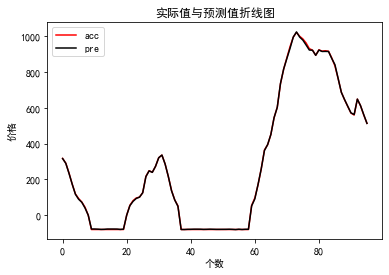

In [32]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
#acc 实际值数据

#pre 预测值数据
 
plt.plot(acc,color="r",label="acc") #颜色表示
 
plt.plot(pre,color=(0,0,0),label="pre") 

plt.xlabel("个数") 
 
plt.ylabel("价格") 
 
plt.title("实际值与预测值折线图") 
 
plt.legend()
 
plt.show() 

In [51]:
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score

In [52]:
print ('均方差',mean_squared_error(acc,pre))
print ('绝对差',mean_absolute_error(acc,pre))
print ('解释度',explained_variance_score(acc,pre))
#print ('MAPE',mean_absolute_percentage_error(acc,pre))

均方差 7.233815908960001
绝对差 1.8344294570615771
解释度 0.999950396176978


In [35]:
y_true = np.array(acc)

In [36]:
y_pred = np.array(pre)

In [37]:
print(y_true)

[ 317.3   290.8   235.6   173.2   118.8    93.     73.28   44.53    0.
  -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.
  -80.    -80.      0.     55.51   81.5    96.27  101.    126.    217.4
  248.6   240.    272.9   321.3   335.78  286.16  215.54  138.17   85.45
   52.44  -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.
  -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.
  -80.    -80.    -80.    -80.    -80.     55.     96.27  170.2   259.6
  364.4   394.    450.76  544.54  603.1   734.28  816.38  880.    942.69
  995.5  1021.34 1000.    985.    962.6   931.    922.42  893.82  924.36
  916.76  919.22  916.2   879.48  834.44  763.12  687.5   645.6   607.88
  570.8   560.    648.6   611.4   559.54  513.86]


In [46]:
print(pre)

0      316.683821
1      289.676916
2      233.639385
3      173.333700
4      117.030574
5       89.122923
6       72.010512
7       40.150409
8        0.077528
9      -77.118954
10     -77.262905
11     -78.080039
12     -79.426991
13     -78.943248
14     -77.368162
15     -77.392285
16     -77.379764
17     -77.570755
18     -79.453942
19     -77.912235
20      -0.094764
21      53.268921
22      77.546227
23      93.758955
24     100.817060
25     125.067047
26     215.525650
27     247.749631
28     239.379911
29     272.949221
30     321.070405
31     336.167115
32     285.645799
33     216.270558
34     136.589131
35      85.161276
36      49.484751
37     -79.876256
38     -80.155307
39     -78.988932
40     -78.816442
41     -78.170907
42     -78.112208
43     -78.285924
44     -79.279060
45     -78.886752
46     -78.145041
47     -78.674715
48     -79.161884
49     -79.150176
50     -79.048371
51     -78.949543
52     -78.466600
53     -79.137913
54     -80.358969
55     -78

In [53]:
mape0=np.mean(np.abs((acc-pre)/acc))*100

In [54]:
print(mape0)
#plt.plot(mape0,color="r",label="MAPE") #颜色表示


inf


In [58]:
y_pred1=np.round(y_pred)

In [59]:
print(y_pred1)

[425. 404. 380. ... 503. 472. 437.]


In [64]:
def mape(y_true, y_pred1):
    return np.mean(np.abs((y_pred1-y_true)/y_true))*100

def smape(y_true, y_pred1):
    return 2.0*np.mean(np.abs(y_pred1-y_true)/(np.abs(y_pred1)+np.abs(y_true)))*100


In [65]:
mape1=np.mean(np.abs((425.2326401 - 426) / 426)) * 100
print(mape1)

0.18013143192487652


In [66]:
print(mape(y_true, y_pred))

inf


<ipython-input-64-3032ec563c95>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_pred1-y_true)/y_true))*100


In [1]:
n=len(acc)
mape=acc-pre

NameError: name 'acc' is not defined